<a href="https://colab.research.google.com/github/MohsenLotfii/School_electricity/blob/main/1_Schools_electricity_(1st_week_of_Feb_2023_24)__31_Oct_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive



Cluster 1 Schools: ['École_Domaine_Vert-Nord']


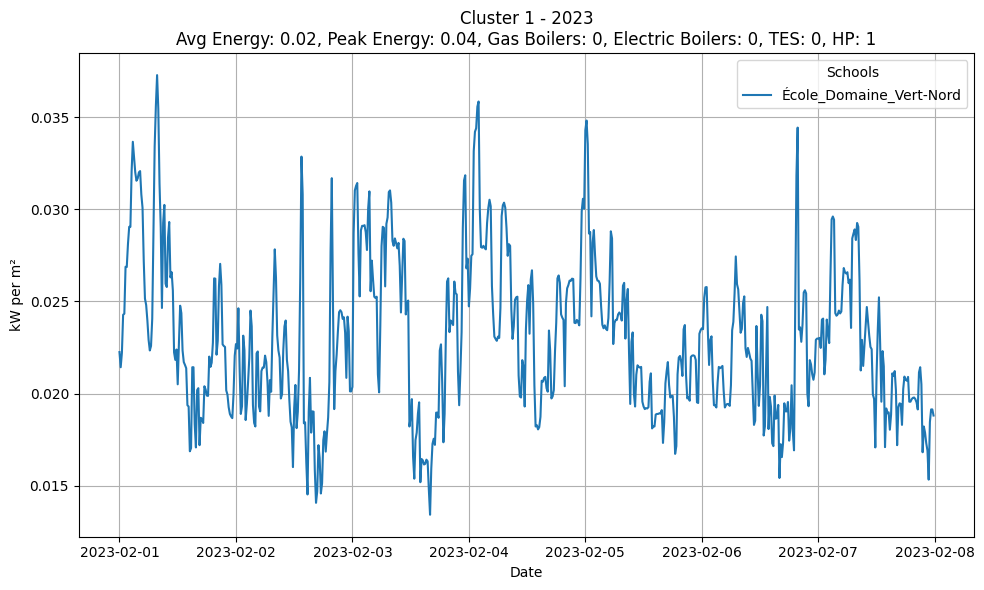


Cluster 2 Schools: ['Alpha', 'Horizon-du-Lac', 'Gaston-Pilon(300209825)', 'Gaston-Pilon(300206515)', 'Gaston-Pilon(300205293)', 'Des_Perséides,pavillon_des_Primevères']


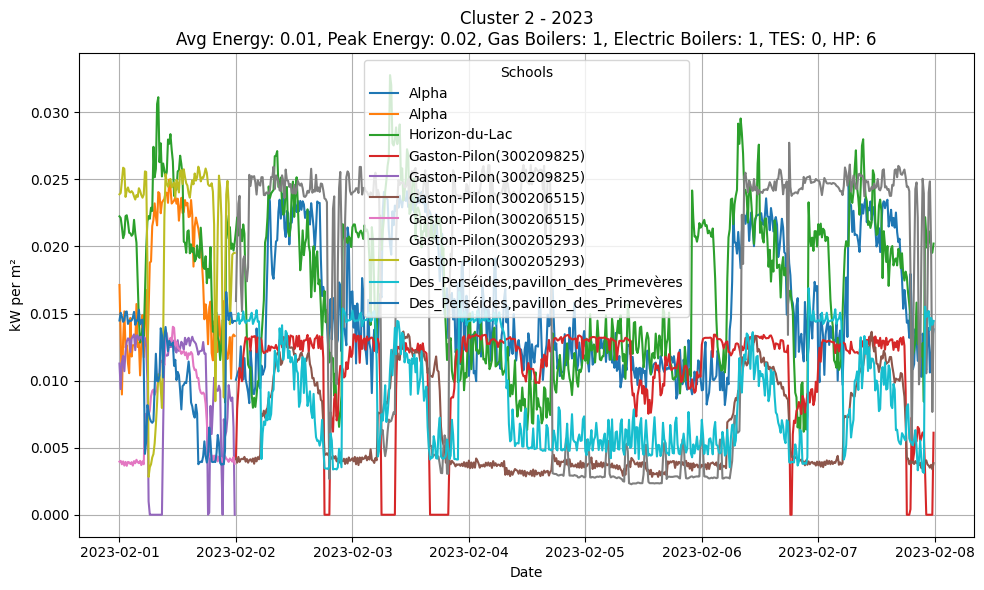


Cluster 3 Schools: ['Marie-Soleil-Tougas', 'De_la_Clé-des-Champs']


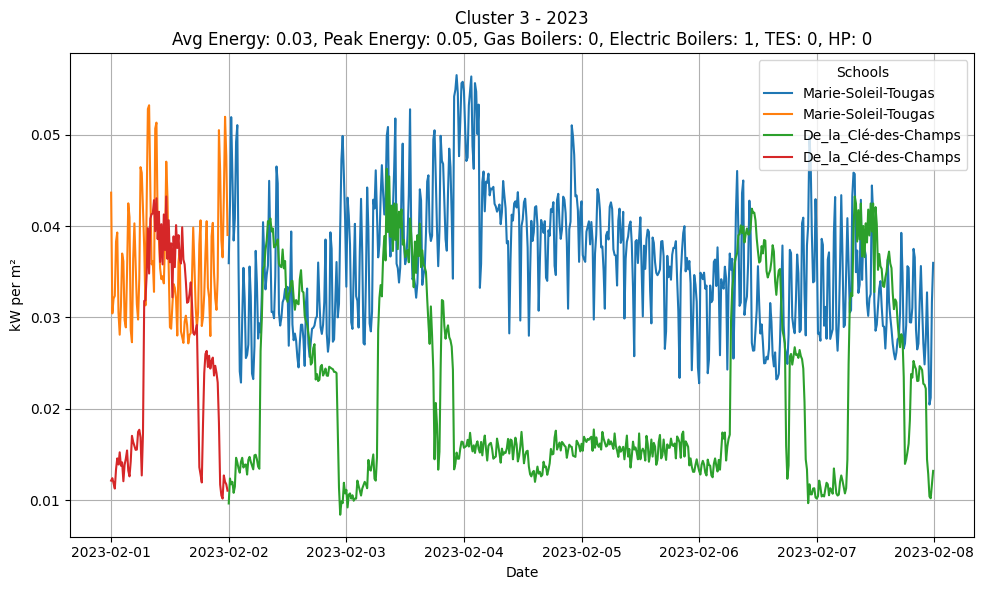


Cluster 1 Schools: ['École_Domaine_Vert-Nord']


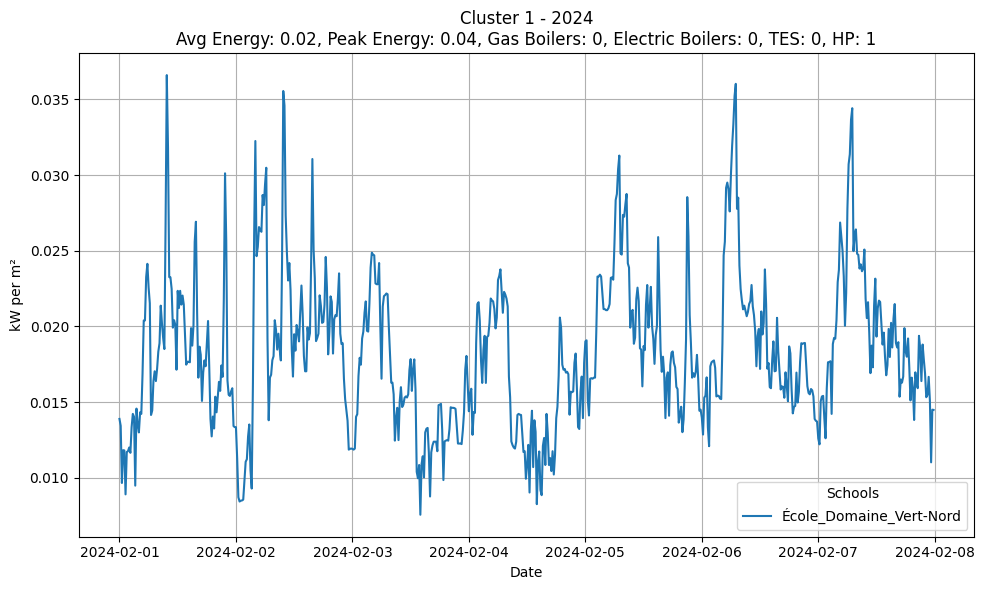


Cluster 2 Schools: ['Alpha', 'Gaston-Pilon(300209825)', 'Gaston-Pilon(300206515)', 'Gaston-Pilon(300205293)', 'Des_Perséides,pavillon_des_Primevères']


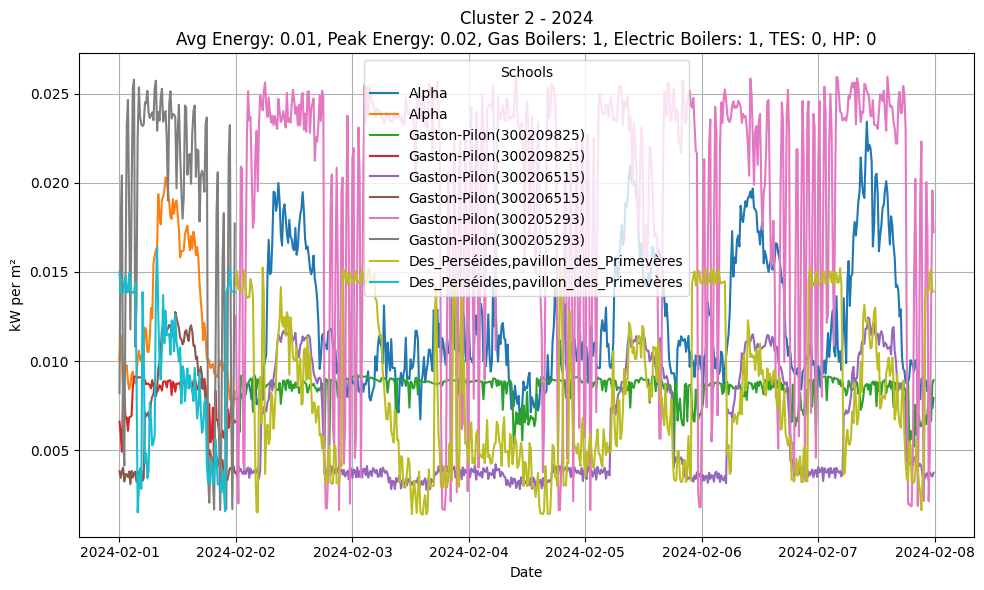


Cluster 3 Schools: ['Horizon-du-Lac', 'Marie-Soleil-Tougas', 'De_la_Clé-des-Champs']


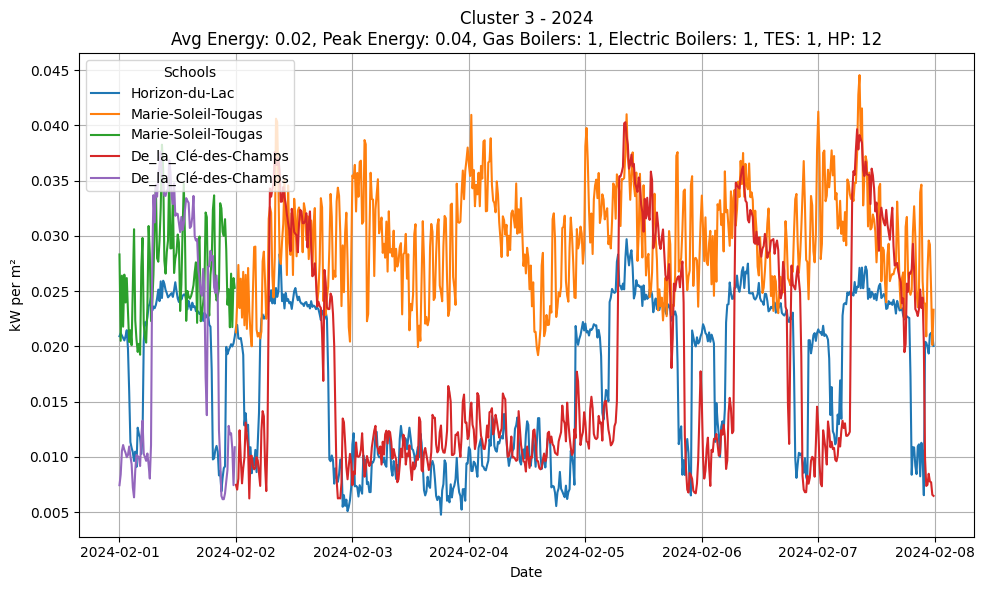

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Floor areas for each school
floorAreas = {
    "Alpha": 7742,
    "Curé-Paquin": 4579,
    "Des_Perséides,pavillon_des_Primevères": 3108,
    "Gaston-Pilon(300209825)": 5103,
    "Gaston-Pilon(300206515)": 5103,
    "Gaston-Pilon(300205293)": 5103,
    "De_la_Clé-des-Champs": 2999,
    "Horizon-du-Lac": 4977,
    "Marie-Soleil-Tougas": 5478,
    "École_Domaine_Vert-Nord": 5717
}

# Mechanical equipment details for each school
equipment = {
    "Alpha": {"Gas Boiler": 3, "Electric Boiler": 1, "TES": 1, "HP": 0},
    "Curé-Paquin": {"Gas Boiler": 0, "Electric Boiler": 1, "TES": 1, "HP": 0, "Radiant Heating": 1, "PV Panel": 1},
    "Des_Perséides,pavillon_des_Primevères": {"Gas Boiler": 0, "Electric Boiler": 1, "TES": 1, "HP": 0},
    "Gaston-Pilon(300209825)": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
    "Gaston-Pilon(300206515)": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
    "Gaston-Pilon(300205293)": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
    "De_la_Clé-des-Champs": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 0, "HP": 0},
    "Horizon-du-Lac": {"Gas Boiler": 1, "Electric Boiler": 1, "TES": 1, "HP": 36},
    "Marie-Soleil-Tougas": {"Gas Boiler": 0, "Electric Boiler": 1, "TES": 1, "HP": 0},
    "École_Domaine_Vert-Nord": {"Gas Boiler": 0, "Electric Boiler": 0, "TES": 0, "HP": 1}
}

# List of paths for different schools
schoolPaths = [
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Alpha",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Horizon-du-Lac",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Marie-Soleil-Tougas",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/De_la_Clé-des-Champs",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/École_Domaine_Vert-Nord",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Gaston-Pilon(300209825)",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Gaston-Pilon(300206515)",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Gaston-Pilon(300205293)",
    "/content/drive/MyDrive/🍁 /UdS/Thesis/Projects/Des_Perséides,pavillon_des_Primevères",
]

# Extract features for clustering
def extract_features(year):
    features = []
    school_names = []

    for schoolPath in schoolPaths:
        school_name = os.path.basename(schoolPath).split('/')[-1]
        floor_area = floorAreas.get(school_name, None)

        if floor_area is None:
            print(f"No floor area found for {school_name}. Skipping.")
            continue

        csv_files = [f for f in os.listdir(schoolPath) if f.endswith('.csv')]
        if not csv_files:
            print(f"No CSV files found in {schoolPath}")
            continue

        energy_data = []
        for file in csv_files:
            full_path = os.path.join(schoolPath, file)

            try:
                df = pd.read_csv(full_path, delimiter=';', decimal=',')
                df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1], errors='coerce')
                df = df.dropna(subset=[df.columns[1]])

                if df.shape[1] >= 3:
                    df.iloc[:, 2] = pd.to_numeric(df.iloc[:, 2], errors='coerce')
                    df = df.dropna(subset=[df.columns[2]])

                    df_filtered = filter_february_first_week(df, year)
                    if not df_filtered.empty:
                        # Calculate average normalized energy consumption
                        normalized_values = df_filtered.iloc[:, 2] / floor_area
                        avg_consumption = normalized_values.mean()
                        peak_consumption = normalized_values.max()
                        energy_data.append([avg_consumption, peak_consumption])

            except Exception as e:
                print(f"Error processing file {file} in {schoolPath}: {e}")

        if energy_data:
            avg_energy = np.mean([d[0] for d in energy_data])
            peak_energy = np.mean([d[1] for d in energy_data])

            # Add mechanical equipment features
            equip_info = equipment.get(school_name, {})
            equip_features = [equip_info.get(key, 0) for key in ["Gas Boiler", "Electric Boiler", "TES", "HP"]]

            # Combine energy and equipment features
            features.append([avg_energy, peak_energy] + equip_features)
            school_names.append(school_name)

    return np.array(features), school_names

# Cluster and plot results
def cluster_and_plot(year, n_clusters=3):
    features, school_names = extract_features(year)

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(features_scaled)

    # Get cluster centroids to interpret clusters
    centroids = kmeans.cluster_centers_
    centroids = scaler.inverse_transform(centroids)  # Undo scaling for interpretability

    # Create cluster descriptions
    cluster_descriptions = []
    for centroid in centroids:
        avg_energy = centroid[0]
        peak_energy = centroid[1]
        gas_boiler_count = int(round(centroid[2]))
        electric_boiler_count = int(round(centroid[3]))
        tes_count = int(round(centroid[4]))
        hp_count = int(round(centroid[5]))

        description = f"Avg Energy: {avg_energy:.2f}, Peak Energy: {peak_energy:.2f}, " \
                      f"Gas Boilers: {gas_boiler_count}, Electric Boilers: {electric_boiler_count}, " \
                      f"TES: {tes_count}, HP: {hp_count}"
        cluster_descriptions.append(description)

    # Plot each cluster with description in the title
    for cluster in range(n_clusters):
        plt.figure(figsize=(10, 6))
        cluster_schools = [school_names[i] for i in range(len(school_names)) if labels[i] == cluster]

        print(f"\nCluster {cluster + 1} Schools: {cluster_schools}")

        for school_name in cluster_schools:
            school_index = school_names.index(school_name)
            schoolPath = schoolPaths[school_index]

            floor_area = floorAreas[school_name]
            csv_files = [f for f in os.listdir(schoolPath) if f.endswith('.csv')]

            for file in csv_files:
                full_path = os.path.join(schoolPath, file)

                try:
                    df = pd.read_csv(full_path, delimiter=';', decimal=',')
                    df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1], errors='coerce')
                    df = df.dropna(subset=[df.columns[1]])

                    if df.shape[1] >= 3:
                        df.iloc[:, 2] = pd.to_numeric(df.iloc[:, 2], errors='coerce')
                        df = df.dropna(subset=[df.columns[2]])

                        df_filtered = filter_february_first_week(df, year)
                        if not df_filtered.empty:
                            normalized_values = df_filtered.iloc[:, 2] / floor_area
                            plt.plot(df_filtered.iloc[:, 1], normalized_values, label=school_name)

                except Exception as e:
                    print(f"Error processing file {file} in {schoolPath}: {e}")

        # Configure plot with descriptive title
        plt.title(f'Cluster {cluster + 1} - {year}\n{cluster_descriptions[cluster]}')
        plt.xlabel('Date')
        plt.ylabel('kW per m²')
        plt.legend(title="Schools")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

# Cluster and plot data for 2023
cluster_and_plot(2023)
cluster_and_plot(2024)


# New Section